In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import object_pixels, get_combined_masks, read_image, mean_f_score, get_masks, get_obj_count

from data import SegmentationDataGenerator

2024-02-22 21:22:52.926364: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 21:22:52.945616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 21:22:52.945634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 21:22:52.946137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 21:22:52.949700: I tensorflow/core/platform/cpu_feature_guar

In [2]:
img_dir = 'airbus-ship-detection/train_v2'

df = pd.read_csv('airbus-ship-detection/train_ship_segmentations_v2.csv')
df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [3]:
print('Number of images without ships:', (no_ships := df['EncodedPixels'].isna()).sum())
print('Number of ships:', (ships := df['EncodedPixels'].notna()).sum())

Number of images without ships: 150000
Number of ships: 81723


In [4]:
print('Number of images with ships:', len(df[ships]['ImageId'].unique()))

Number of images with ships: 42556


In [5]:
ships_count = df.groupby('ImageId').agg({'EncodedPixels': 'count'})
ships_count = ships_count.rename(columns={'EncodedPixels' : 'number_of_ships'})
ships_count

,number_of_ships
ImageId,
00003e153.jpg,0
0001124c7.jpg,0
000155de5.jpg,1
000194a2d.jpg,5
0001b1832.jpg,0
...,...
fffedbb6b.jpg,0
ffff2aa57.jpg,0
ffff6e525.jpg,0


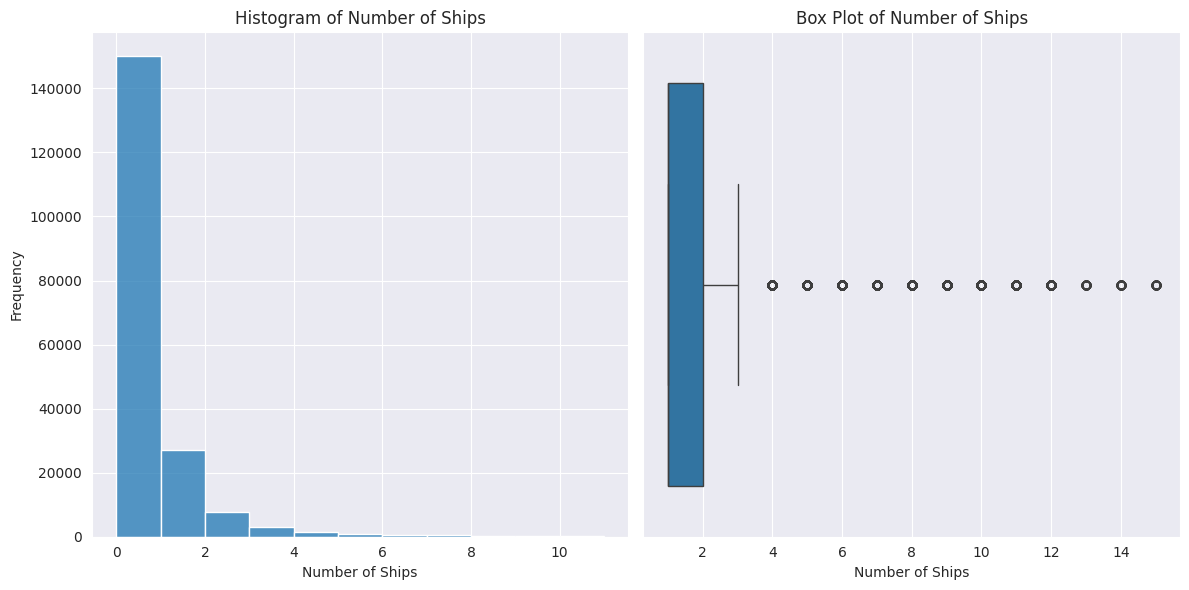

In [6]:
plt.figure(figsize=(12, 6))

# Histogram of Number of Ships
plt.subplot(1, 2, 1)
sns.histplot(ships_count['number_of_ships'], bins=range(12), kde=False)
plt.title('Histogram of Number of Ships')
plt.xlabel('Number of Ships')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=ships_count[ships_count['number_of_ships'] != 0]['number_of_ships'])
plt.title('Box Plot of Number of Ships')
plt.xlabel('Number of Ships')

plt.tight_layout()
plt.show()

In [7]:
ships_count.value_counts()

number_of_ships
0                  150000
1                   27104
2                    7674
3                    2954
4                    1622
5                     925
6                     657
7                     406
8                     318
9                     243
10                    168
11                    144
12                    124
14                     76
13                     75
15                     66
Name: count, dtype: int64

count    81723.000000
mean      1567.402849
std       2842.081203
min          2.000000
25%        111.000000
50%        408.000000
75%       1550.000000
max      25904.000000
Name: EncodedPixels, dtype: float64

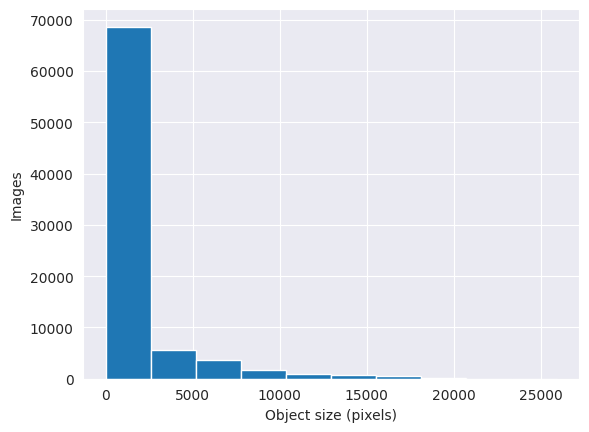

In [8]:
obj_pixels = df.dropna().EncodedPixels.map(lambda x: object_pixels(x))

obj_pixels.hist()
plt.xlabel('Object size (pixels)')
plt.ylabel('Images')

obj_pixels.describe()

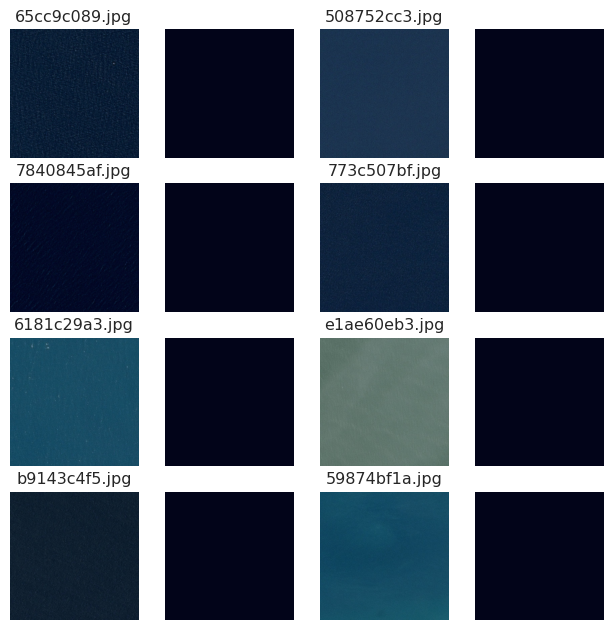

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8), dpi=96)

ax = ax.reshape(-1)

for a in ax:
    a.axis('off')

img_ids = np.random.choice(df[df['EncodedPixels'].isna()]['ImageId'], 8, replace=False)

for i, img_id in enumerate(img_ids):
    msk = get_combined_masks(img_id, df)
    ax[2 * i].imshow(read_image(img_id, img_dir))
    ax[2 * i].set_title(img_id)
    ax[2 * i + 1].imshow(msk)

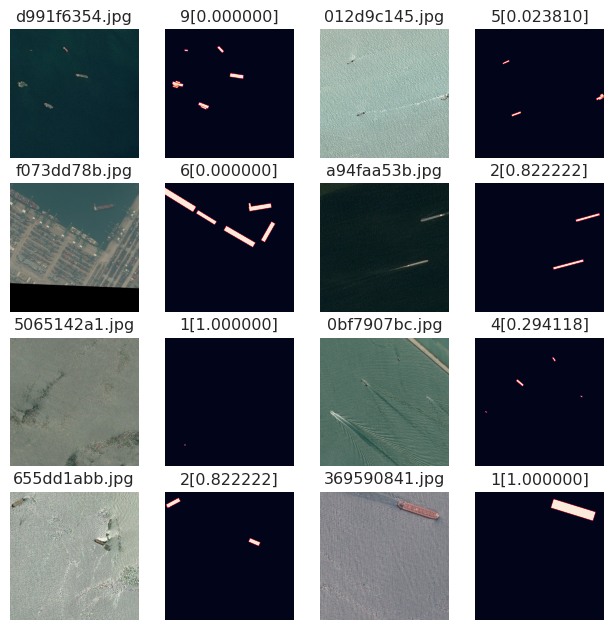

In [10]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8), dpi=96)

ax = ax.reshape(-1)

for a in ax:
    a.axis('off')

img_ids = np.random.choice(df[df['EncodedPixels'].notna()]['ImageId'], 8, replace=False)

for i, img_id in enumerate(img_ids):
    msk = get_combined_masks(img_id, df)
    avg_f_score = mean_f_score([msk], get_masks(img_id, df))
    ax[2 * i].imshow(read_image(img_id, img_dir))
    ax[2 * i].set_title(img_id)
    ax[2 * i + 1].imshow(msk)
    ax[2 * i + 1].set_title("%s[%f]" % (get_obj_count(img_id, df), avg_f_score))

In [11]:
batch_size = 16
img_size = (384, 384)
destination_dataset_path = 'datasets/airbus_ship'

train_gen = SegmentationDataGenerator(directory=destination_dataset_path,
                                      batch_size=batch_size,
                                      subset='train',
                                      img_size=img_size)

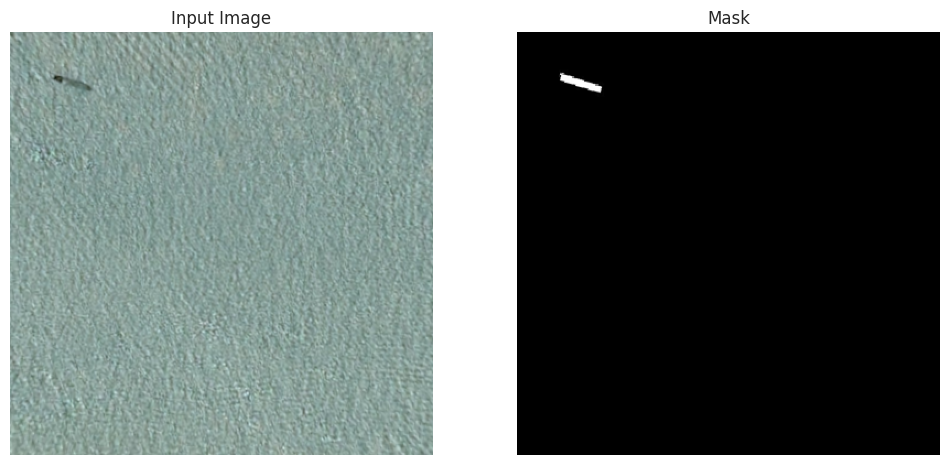

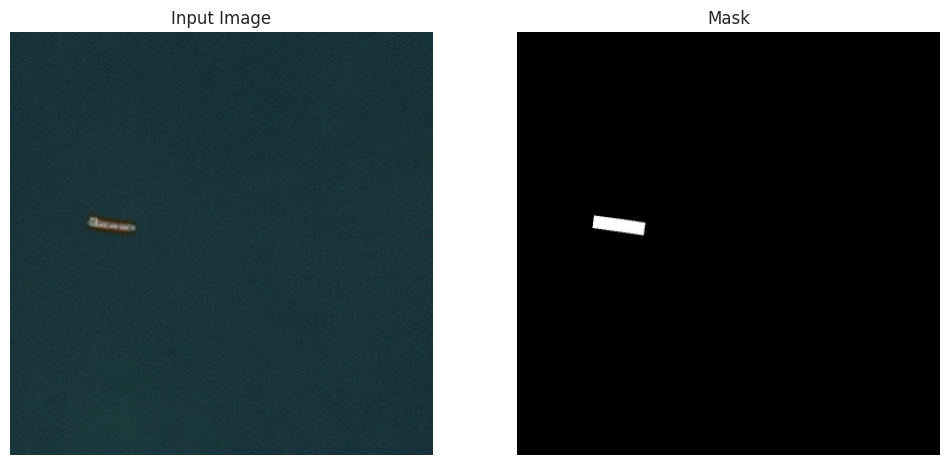

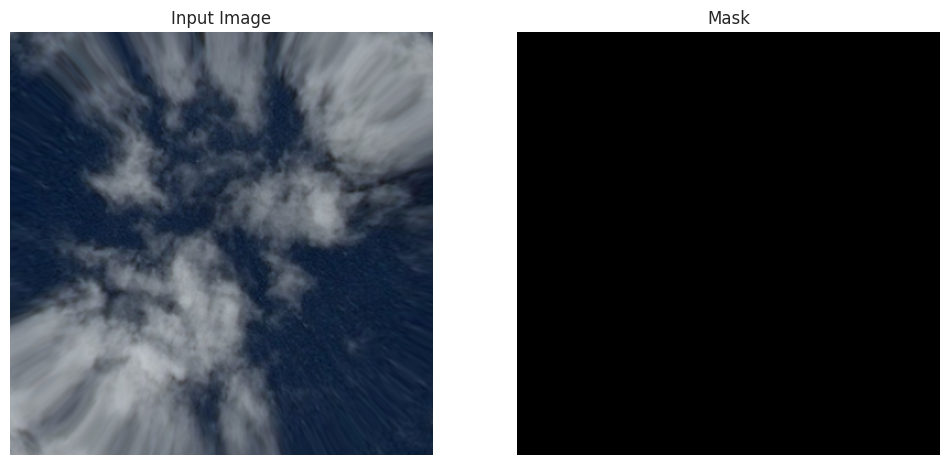

In [12]:
train_gen.show_batch(num_examples=3)

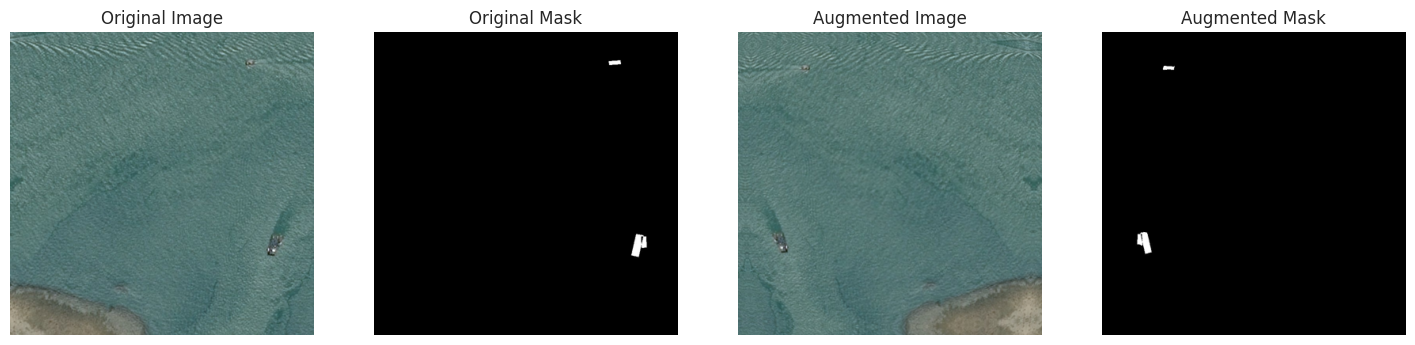

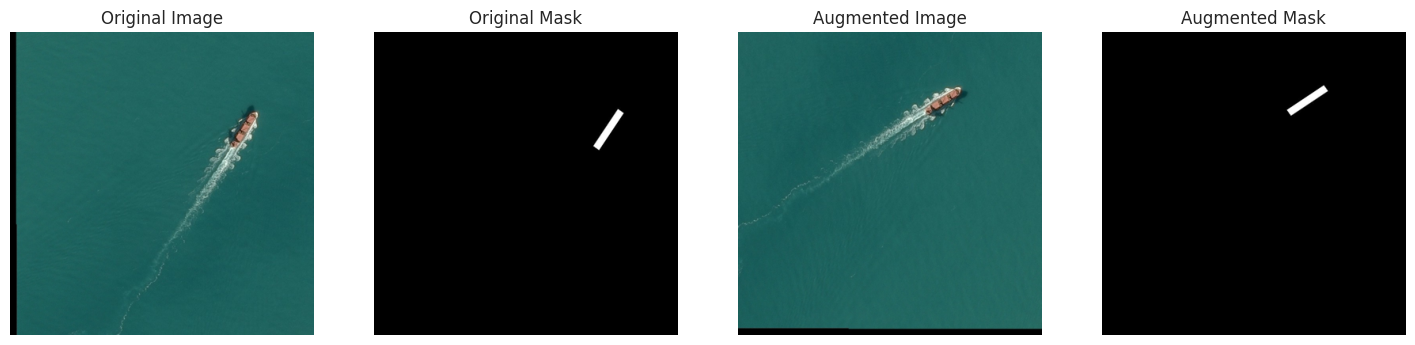

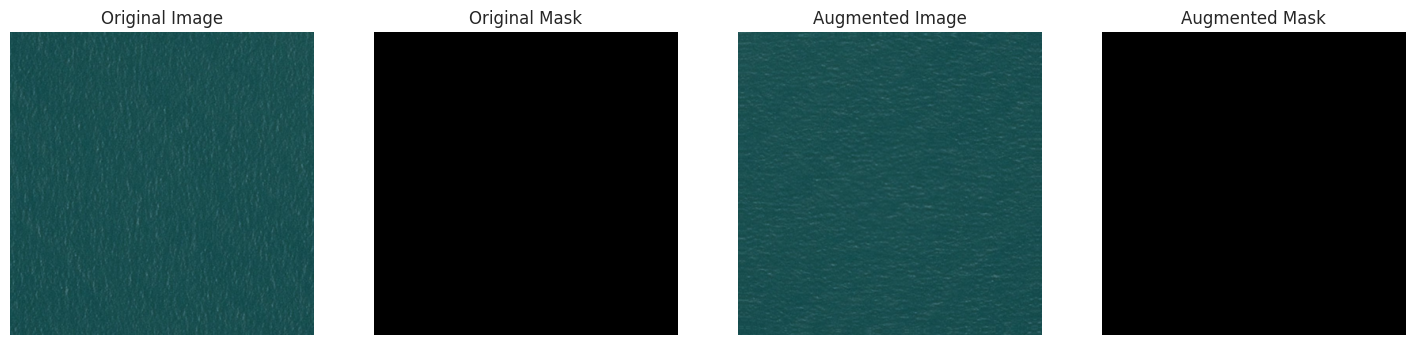

In [13]:
train_gen.show_comparison()